# Simple Model Testing

Basic testing for the plant disease model.

In [3]:
import tensorflow as tf
import numpy as np
from keras.utils import load_img, img_to_array
import os

# Paths
MODEL_PATH = "../models/plant_disease__binary_model.tflite"
DATA_DIR = "../data/custom"

print("Ready to test!")

2025-08-29 02:24:16.519601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756434256.731823    4146 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756434256.786597    4146 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756434257.266792    4146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756434257.266870    4146 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756434257.266876    4146 computation_placer.cc:177] computation placer alr

Ready to test!


In [4]:
# Load model
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded!")

Model loaded!


/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
# Test an image
image_name = "healthy_tomato.jpg"  # Change this to your image name
image_path = os.path.join(DATA_DIR, image_name)

# Load and preprocess
img = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = tf.image.random_brightness(img_array, 0.2)
img_array = tf.image.random_contrast(img_array, 0.8, 1.2)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype(np.float32) / 255.0

# Predict
interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]

# Result
if prediction > 0.5:
    result = "DISEASED"
else:
    result = "HEALTHY"

print(f"Image: {image_name}")
print(f"Prediction: {result}")
print(f"Score: {prediction:.3f}")

Image: healthy_tomato.jpg
Prediction: HEALTHY
Score: 0.364


I0000 00:00:1756434365.628962    4146 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1741 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:02:00.0, compute capability: 6.1


In [6]:
# ============= INFERENCE TIME MEASUREMENT =============
import time
import statistics
import matplotlib.pyplot as plt
MODEL_PATH = "../models/plant_disease__binary_model.tflite"

def measure_inference_time(interpreter, input_data, num_runs=100, warmup_runs=10):
    """
    Measure inference time with multiple runs for statistical accuracy
    
    Args:
        interpreter: TFLite interpreter
        input_data: Preprocessed input tensor
        num_runs: Number of inference runs for measurement
        warmup_runs: Number of warmup runs (excluded from timing)
    
    Returns:
        dict: Statistical summary of inference times
    """
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Warmup runs (excluded from timing)
    print(f"Performing {warmup_runs} warmup runs...")
    for _ in range(warmup_runs):
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        _ = interpreter.get_tensor(output_details[0]['index'])
    
    # Actual timing runs
    print(f"Measuring inference time over {num_runs} runs...")
    inference_times = []
    
    for i in range(num_runs):
        start_time = time.perf_counter()
        
        # Inference
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        prediction = interpreter.get_tensor(output_details[0]['index'])
        
        end_time = time.perf_counter()
        
        inference_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
        inference_times.append(inference_time_ms)
        
        if (i + 1) % 20 == 0:
            print(f"  Completed {i + 1}/{num_runs} runs")
    
    # Calculate statistics
    stats = {
        'mean_ms': statistics.mean(inference_times),
        'median_ms': statistics.median(inference_times),
        'min_ms': min(inference_times),
        'max_ms': max(inference_times),
        'std_ms': statistics.stdev(inference_times) if len(inference_times) > 1 else 0,
        'p95_ms': sorted(inference_times)[int(0.95 * len(inference_times))],
        'p99_ms': sorted(inference_times)[int(0.99 * len(inference_times))],
        'all_times': inference_times
    }
    
    return stats

# Use the same preprocessed image from above
print("="*60)
print("INFERENCE TIME MEASUREMENT")
print("="*60)
print(f"Model: {MODEL_PATH}")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Image: {image_name}")
print("-"*60)

# Measure inference time
timing_stats = measure_inference_time(interpreter, img_array, num_runs=100, warmup_runs=10)

# Display results
print("\nINFERENCE TIME STATISTICS:")
print("-"*30)
print(f"Mean:       {timing_stats['mean_ms']:.3f} ms")
print(f"Median:     {timing_stats['median_ms']:.3f} ms")
print(f"Min:        {timing_stats['min_ms']:.3f} ms")
print(f"Max:        {timing_stats['max_ms']:.3f} ms")
print(f"Std Dev:    {timing_stats['std_ms']:.3f} ms")
print(f"95th %ile:  {timing_stats['p95_ms']:.3f} ms")
print(f"99th %ile:  {timing_stats['p99_ms']:.3f} ms")

# Performance evaluation based on your research objectives
print("\nPERFORMANCE EVALUATION:")
print("-"*30)
mean_inference_time = timing_stats['mean_ms']
if mean_inference_time < 100:  # Less than 100ms
    performance_rating = "EXCELLENT ✅"
elif mean_inference_time < 500:  # Less than 500ms  
    performance_rating = "GOOD ✅"
elif mean_inference_time < 1000:  # Less than 1 second (your objective)
    performance_rating = "ACCEPTABLE ⚠️"
else:
    performance_rating = "NEEDS OPTIMIZATION ❌"

print(f"Rating: {performance_rating}")
print(f"Target: <1000ms (1s) for edge deployment")
print(f"Achieved: {mean_inference_time:.1f}ms ({mean_inference_time/1000:.3f}s)")

# FPS calculation
fps = 1000 / mean_inference_time
print(f"Theoretical FPS: {fps:.1f}")

print("\nMODEL SIZE INFORMATION:")
print("-"*30)
model_size_bytes = os.path.getsize(MODEL_PATH)
model_size_kb = model_size_bytes / 1024
model_size_mb = model_size_kb / 1024
print(f"Model size: {model_size_bytes:,} bytes ({model_size_kb:.1f} KB, {model_size_mb:.2f} MB)")

INFERENCE TIME MEASUREMENT
Model: ../models/plant_disease__binary_model.tflite
Input shape: [  1 128 128   3]
Image: healthy_tomato.jpg
------------------------------------------------------------
Performing 10 warmup runs...
Measuring inference time over 100 runs...
  Completed 20/100 runs
  Completed 40/100 runs
  Completed 60/100 runs
  Completed 80/100 runs
  Completed 100/100 runs

INFERENCE TIME STATISTICS:
------------------------------
Mean:       3.116 ms
Median:     2.970 ms
Min:        2.793 ms
Max:        4.345 ms
Std Dev:    0.333 ms
95th %ile:  4.075 ms
99th %ile:  4.345 ms

PERFORMANCE EVALUATION:
------------------------------
Rating: EXCELLENT ✅
Target: <1000ms (1s) for edge deployment
Achieved: 3.1ms (0.003s)
Theoretical FPS: 320.9

MODEL SIZE INFORMATION:
------------------------------
Model size: 9,516,268 bytes (9293.2 KB, 9.08 MB)
  Completed 60/100 runs
  Completed 80/100 runs
  Completed 100/100 runs

INFERENCE TIME STATISTICS:
------------------------------
Mea

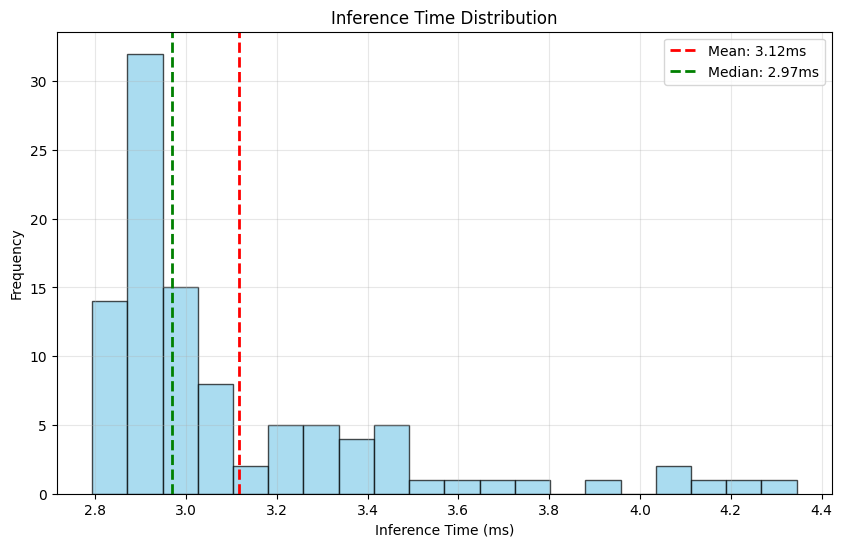

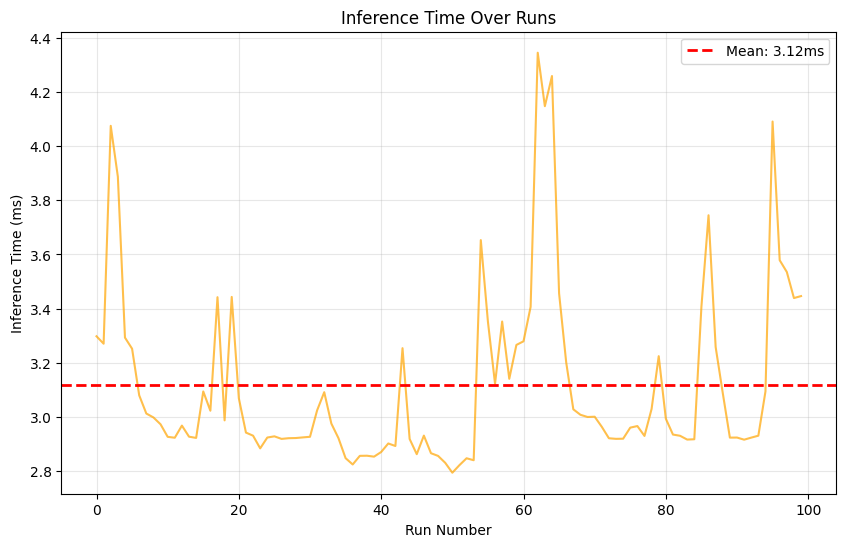

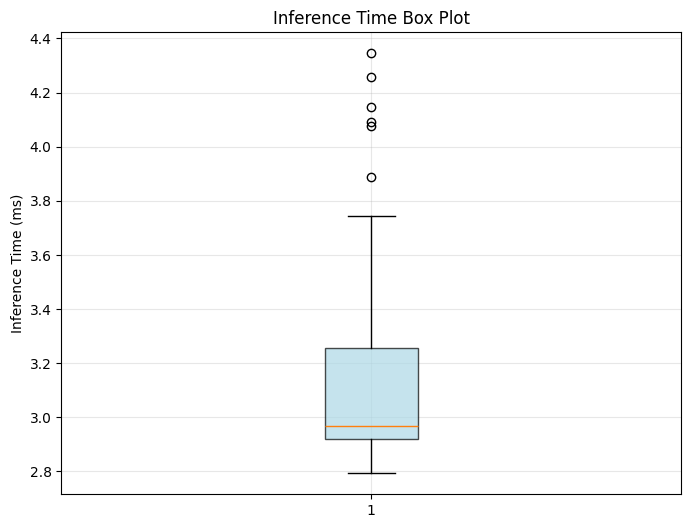


SUMMARY FOR EDGE DEPLOYMENT
✓ Model Size: 9.08 MB (Good for edge devices)
✓ Average Inference: 3.1ms
✓ 95% of inferences: <4.1ms
✓ Theoretical throughput: 320.9 FPS
✅ MEETS EDGE REQUIREMENTS: <1s inference time

RECOMMENDations FOR FURTHER OPTIMIZATION:
- Quantization (INT8) could reduce inference time by 2-4x
- Model pruning could reduce size and improve speed
- Consider MobileNetV3 or EfficientNet-Lite for better efficiency
- GPU acceleration (if available on target device)


In [18]:
# ============= VISUALIZATION =============

# Plot 1: Histogram of inference times
plt.figure(figsize=(10, 6))
plt.hist(timing_stats['all_times'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(timing_stats['mean_ms'], color='red', linestyle='--', linewidth=2, label=f'Mean: {timing_stats["mean_ms"]:.2f}ms')
plt.axvline(timing_stats['median_ms'], color='green', linestyle='--', linewidth=2, label=f'Median: {timing_stats["median_ms"]:.2f}ms')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Frequency')
plt.title('Inference Time Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Time series of inference times
plt.figure(figsize=(10, 6))
plt.plot(timing_stats['all_times'], alpha=0.7, color='orange')
plt.axhline(timing_stats['mean_ms'], color='red', linestyle='--', linewidth=2, label=f'Mean: {timing_stats["mean_ms"]:.2f}ms')
plt.xlabel('Run Number')
plt.ylabel('Inference Time (ms)')
plt.title('Inference Time Over Runs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: Box plot
plt.figure(figsize=(8, 6))
plt.boxplot(timing_stats['all_times'], patch_artist=True, 
           boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.ylabel('Inference Time (ms)')
plt.title('Inference Time Box Plot')
plt.grid(True, alpha=0.3)
plt.show()

# Summary table
print("\n" + "="*60)
print("SUMMARY FOR EDGE DEPLOYMENT")
print("="*60)
print(f"✓ Model Size: {model_size_mb:.2f} MB (Good for edge devices)")
print(f"✓ Average Inference: {timing_stats['mean_ms']:.1f}ms")
print(f"✓ 95% of inferences: <{timing_stats['p95_ms']:.1f}ms")
print(f"✓ Theoretical throughput: {fps:.1f} FPS")

if mean_inference_time < 1000:
    print("✅ MEETS EDGE REQUIREMENTS: <1s inference time")
else:
    print("❌ OPTIMIZATION NEEDED: Exceeds 1s target")

print("\nRECOMMENDations FOR FURTHER OPTIMIZATION:")
print("- Quantization (INT8) could reduce inference time by 2-4x")
print("- Model pruning could reduce size and improve speed")
print("- Consider MobileNetV3 or EfficientNet-Lite for better efficiency")
print("- GPU acceleration (if available on target device)")